## Welcome to the Drug Response Exploration Tutorial
We will be exploring the BeatAML, Depmap/Sanger, and MPNST Datasets based on a few different criteria.
We will explore the following:
- Which drugs are most prevalent within and across datasets.
- How AUC/ IC50 are distributed across cancer type and model type of top 5-10 drugs.
- Differences between drug response for MEK inhibitors across different RAS mutations. 

In [1]:
import pandas as pd
import numpy as np
import coderdata as cd
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Datasets

Load in the datasets and create a merged dataset.

In [5]:
beataml = cd.DatasetLoader("beataml")
depmap = cd.DatasetLoader("broad_sanger")
mpnst = cd.DatasetLoader("mpnst")


Processing Data...
Loaded genes dataset.
Processing Data...
Loaded genes dataset.
Processing Data...
Loaded genes dataset.


In [6]:
joined_data = cd.join_datasets(depmap,beataml,mpnst)

Processing Data...
Loaded genes dataset.


#### Small Structure Adjustments

Get the data in the right format for this exploration such as changing types to floats so mapping work correcly.

In [7]:
joined_data.experiments = joined_data.experiments[joined_data.experiments.dose_response_metric != "dose_response_metric"]
joined_data.experiments['dose_response_metric'] = joined_data.experiments['dose_response_metric'].str.replace(' ', '_', regex=False)
joined_data.experiments.dose_response_value = joined_data.experiments.dose_response_value.astype(float)
joined_data.experiments.improve_sample_id = joined_data.experiments.improve_sample_id.astype(float).astype(int)
joined_data.samples.improve_sample_id = joined_data.samples.improve_sample_id.astype(float).astype(int)
joined_data.experiments.dose_response_value =joined_data.experiments.dose_response_value.astype(float)
joined_data.mutations['improve_sample_id'] = pd.to_numeric(joined_data.mutations['improve_sample_id'], errors='coerce').astype('Int64')

#### View Data

Examine the data we are working with.

In [10]:
joined_data.experiments

source  improve_sample_id improve_drug_id          study time  \
0         pharmacoGX                  1         SMI_106           CCLE   72   
1         pharmacoGX                  1         SMI_112           CCLE   72   
2         pharmacoGX                  1        SMI_1182           CCLE   72   
3         pharmacoGX                  1         SMI_154           CCLE   72   
4         pharmacoGX                  1         SMI_169           CCLE   72   
...              ...                ...             ...            ...  ...   
2635  NF Data Portal               5153         SMI_329  MT 210609 exp   48   
2636  NF Data Portal               5153         SMI_400  MT 210609 exp   48   
2637  NF Data Portal               5153         SMI_469  MT 210609 exp   48   
2638  NF Data Portal               5153         SMI_803  MT 210609 exp   48   
2639  NF Data Portal               5153         SMI_880  MT 210609 exp   48   

     time_unit dose_response_metric  dose_response_value  
0        hours              fit_auc               0.4910  
1        hours              fit_auc               0.9446  
2        hours              fit_auc               0.8698  
3        hours              fit_auc               0.7830  
4        hours              fit_auc               0.5841  
...        ...                  ...                  ...  
2635     hours                  dss               0.9976  
2636     hours                  dss               0.9971  
2637     hours                  dss               0.9982  
2638     hours                  dss               0.9968  
2639     hours                  dss               0.9967  

[42273090 rows x 8 columns]

### Subset the Data by Reponse Metrics

We are most interested in AUC and IC50, here we will subset to only include these values

In [12]:
dose_response_metric_of_interest = ["fit_auc","fit_ic50"]
joined_data.experiments = joined_data.experiments[joined_data.experiments['dose_response_metric'].isin(dose_response_metric_of_interest)]

### Merge in Cancer type and Model Type 

By merging in cancer and model type, we can more easily explore our data and generate hypotheses.

In [13]:
merged_data = pd.merge(joined_data.experiments, joined_data.samples[['improve_sample_id', 'cancer_type', 'model_type']], 
                       on='improve_sample_id', how='inner')

In [44]:
merged_data

source  improve_sample_id improve_drug_id          study  \
0              pharmacoGX                  1         SMI_106           CCLE   
1              pharmacoGX                  1         SMI_106           CCLE   
2              pharmacoGX                  1         SMI_106           CCLE   
3              pharmacoGX                  1         SMI_106           CCLE   
4              pharmacoGX                  1         SMI_106           CCLE   
...                   ...                ...             ...            ...   
306594693  NF Data Portal               5153         SMI_329  MT 210609 exp   
306594694  NF Data Portal               5153         SMI_400  MT 210609 exp   
306594695  NF Data Portal               5153         SMI_469  MT 210609 exp   
306594696  NF Data Portal               5153         SMI_803  MT 210609 exp   
306594697  NF Data Portal               5153         SMI_880  MT 210609 exp   

          time time_unit dose_response_metric  dose_response_value  \
0           72     hours              fit_auc                0.491   
1           72     hours              fit_auc                0.491   
2           72     hours              fit_auc                0.491   
3           72     hours              fit_auc                0.491   
4           72     hours              fit_auc                0.491   
...        ...       ...                  ...                  ...   
306594693   48     hours             fit_ic50                8.921   
306594694   48     hours             fit_ic50                8.986   
306594695   48     hours             fit_ic50               10.320   
306594696   48     hours             fit_ic50               10.320   
306594697   48     hours             fit_ic50               12.000   

                                       cancer_type model_type  
0                             Pancreatic Carcinoma  cell line  
1                             Pancreatic Carcinoma  cell line  
2                             Pancreatic Carcinoma  cell line  
3                             Pancreatic Carcinoma  cell line  
4                             Pancreatic Carcinoma  cell line  
...                                            ...        ...  
306594693  Malignant peripheral nerve sheath tumor   organoid  
306594694  Malignant peripheral nerve sheath tumor   organoid  
306594695  Malignant peripheral nerve sheath tumor   organoid  
306594696  Malignant peripheral nerve sheath tumor   organoid  
306594697  Malignant peripheral nerve sheath tumor   organoid  

[306594698 rows x 10 columns]

####  Find most Common Drug Types

We will begin by exploring the most prevalent drug types in our data

In [14]:
# Count unique combinations of model_type and cancer_type for each drug
drug_diversity = merged_data.groupby('improve_drug_id').apply(lambda x: x[['model_type', 'cancer_type']].drop_duplicates().shape[0]).reset_index(name='unique_combinations')
top_drugs = drug_diversity.sort_values(by='unique_combinations', ascending=False).head(10)


### Plot AUC Values for the Top Drugs by Cancer Types - Bar plots


These bar plots are generated in a similar style as PharmacoGX.

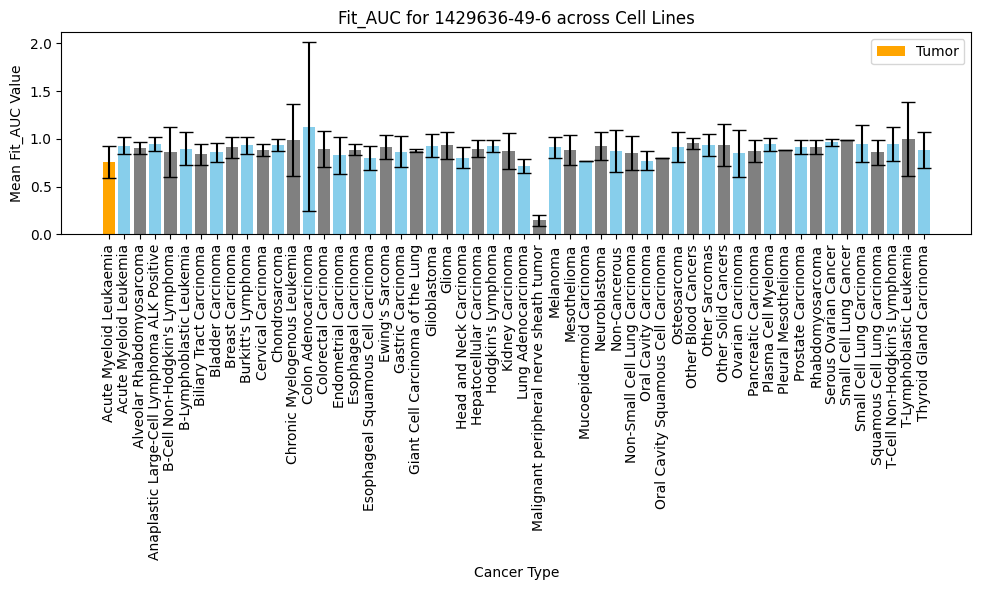

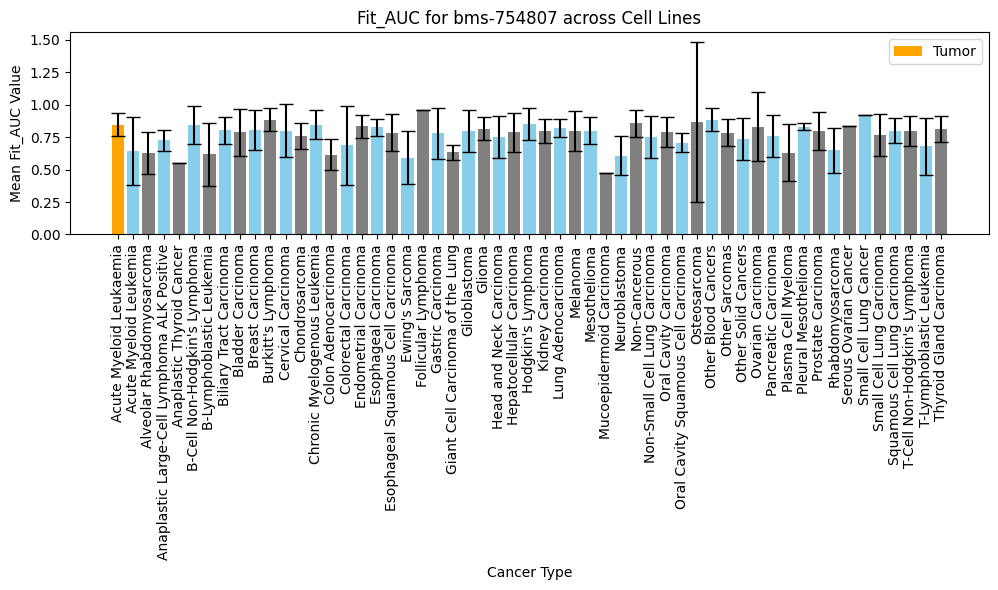

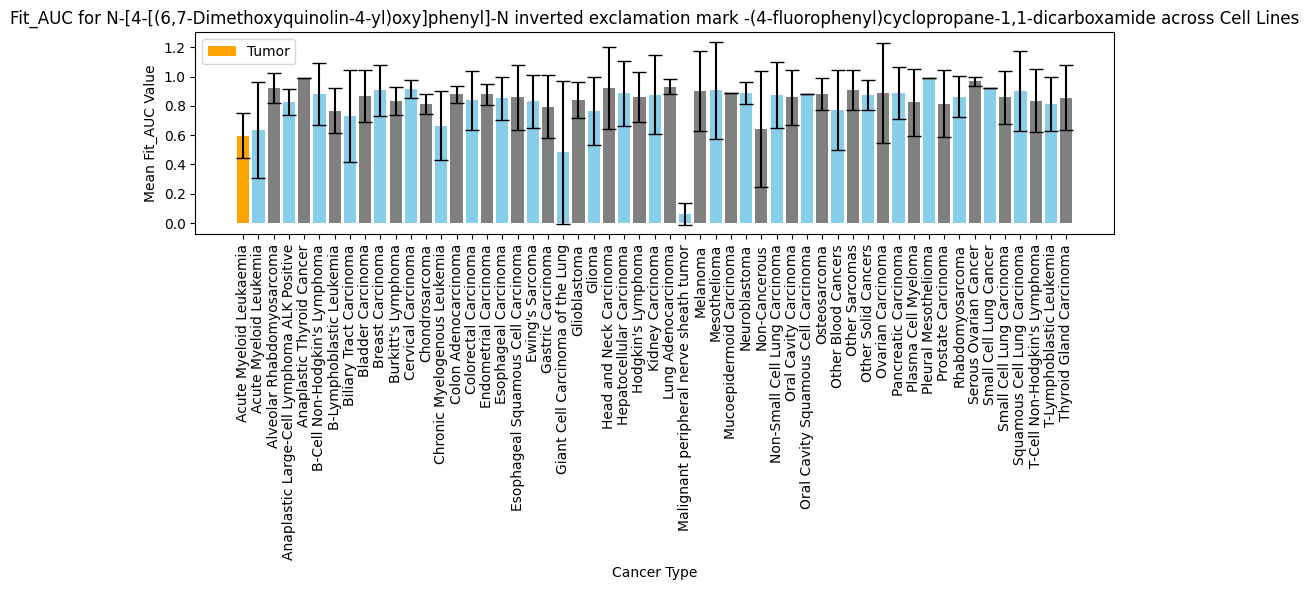

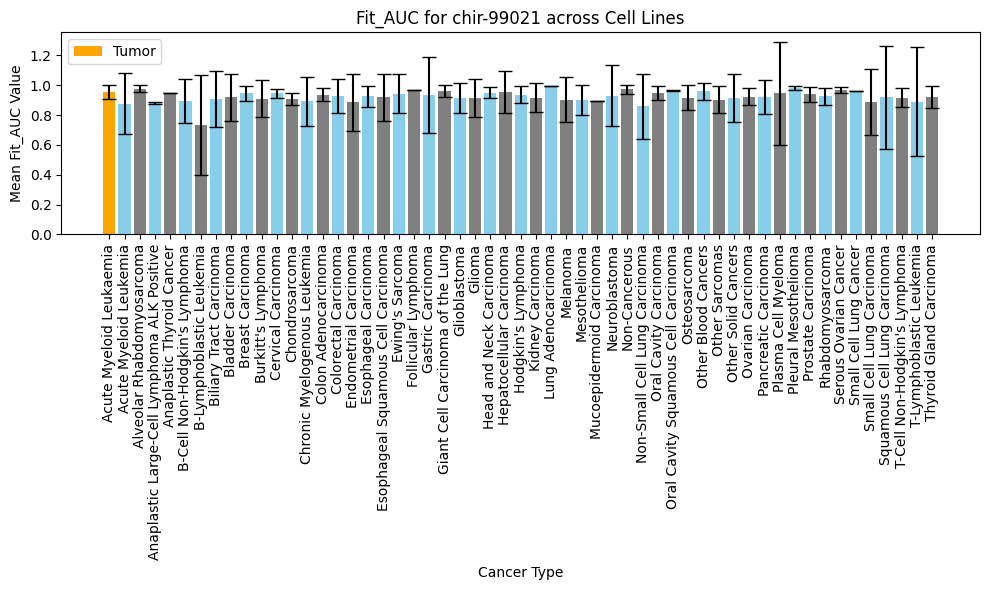

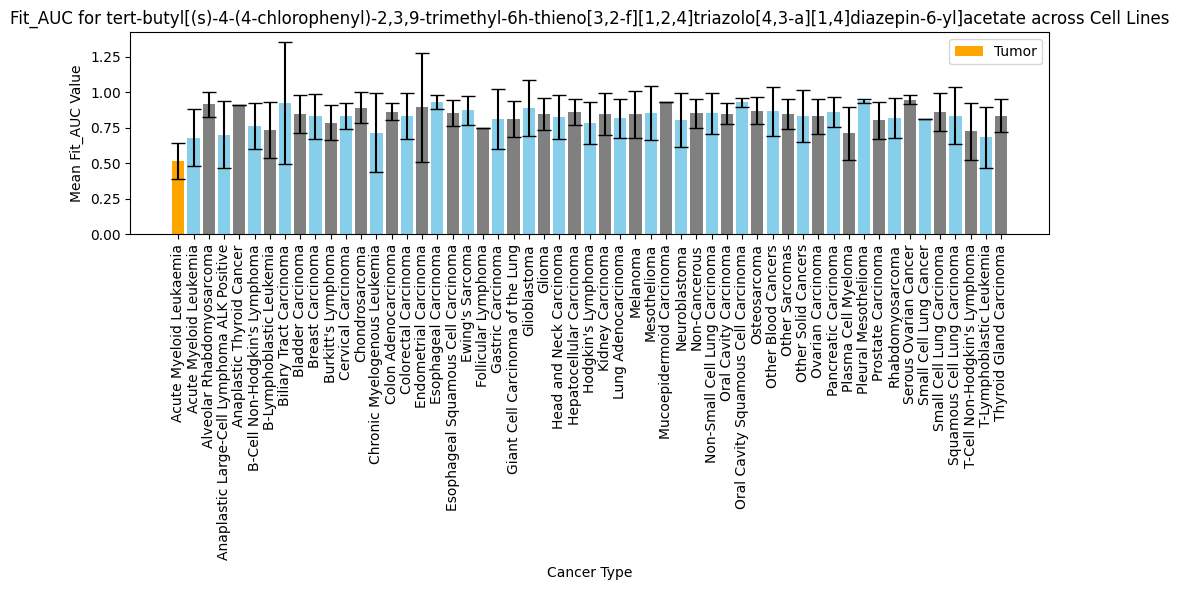

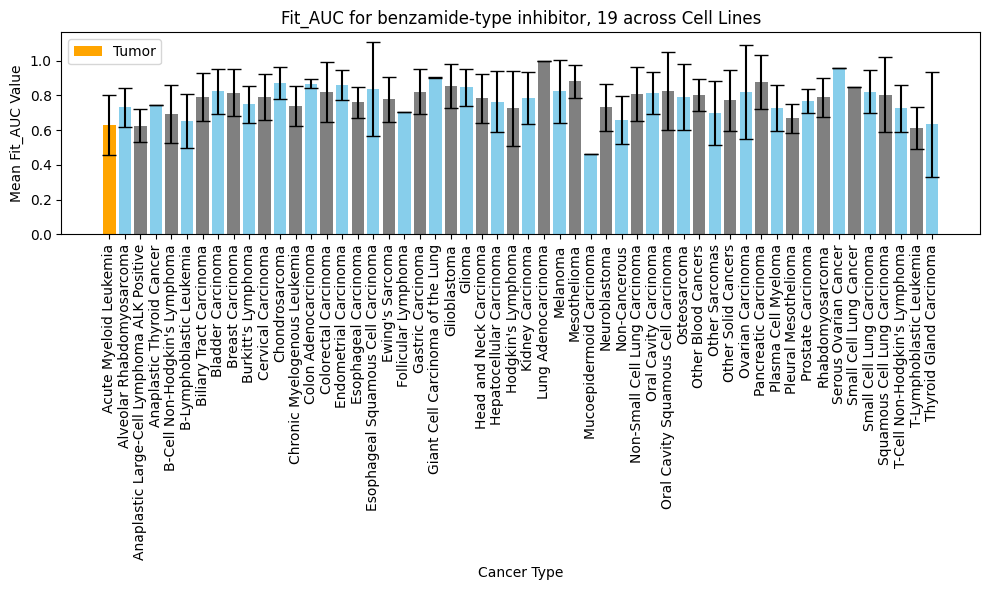

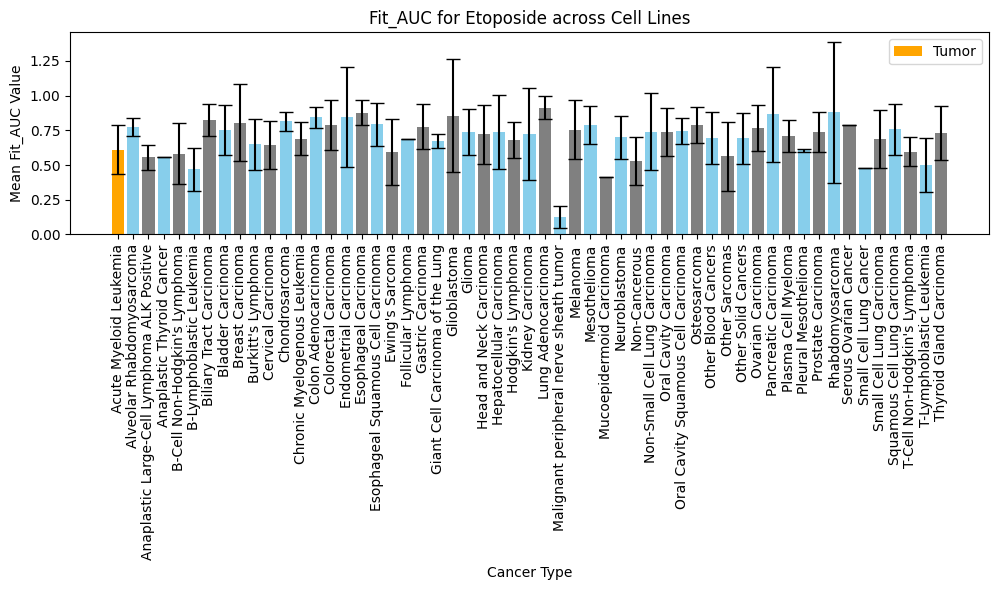

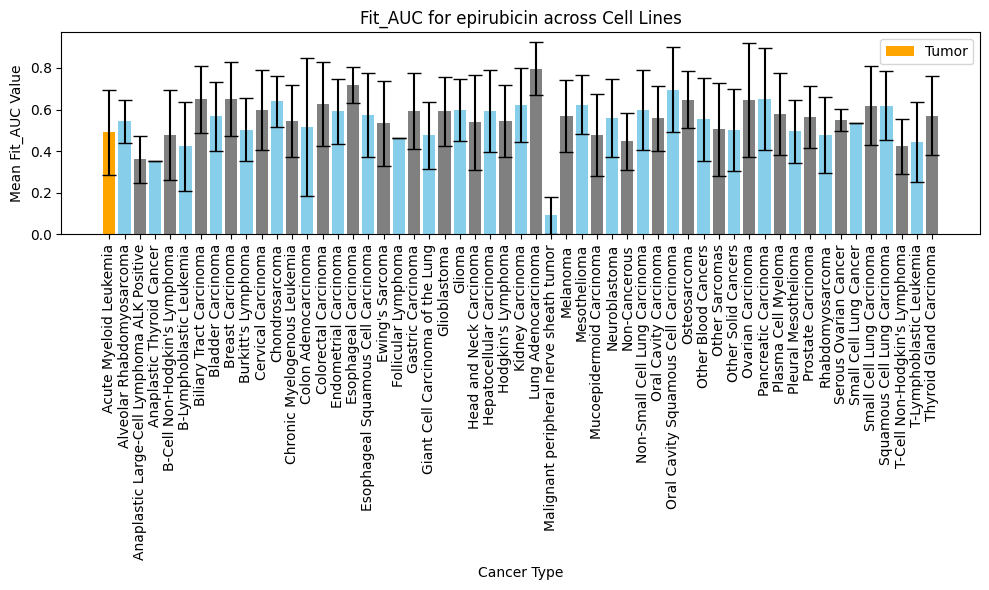

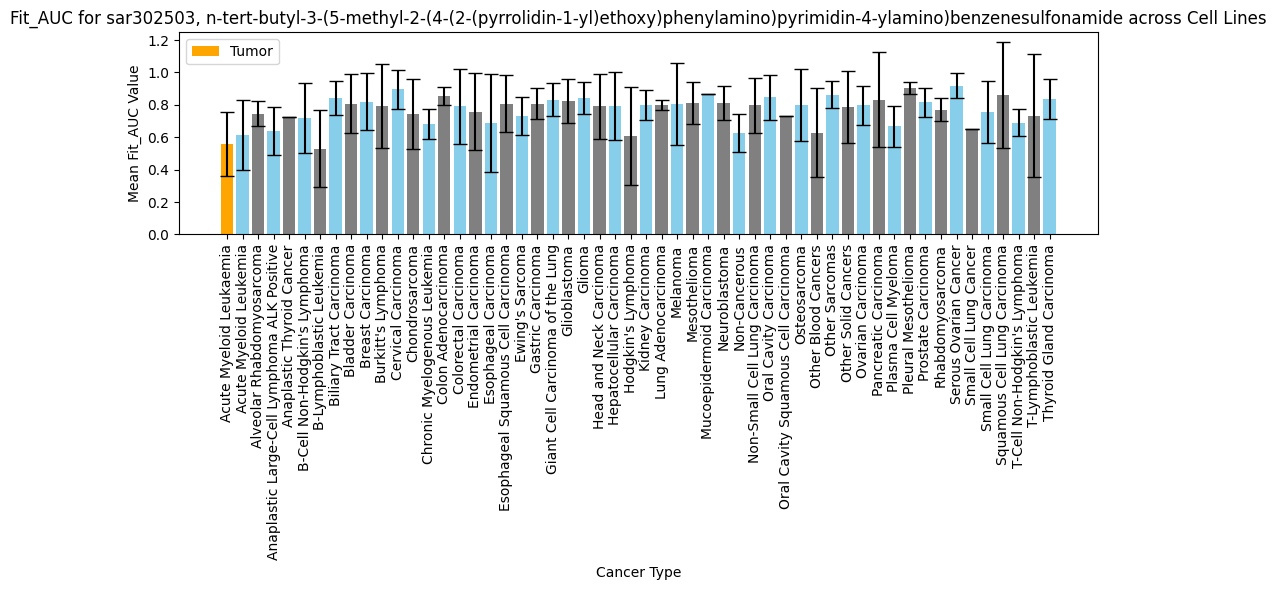

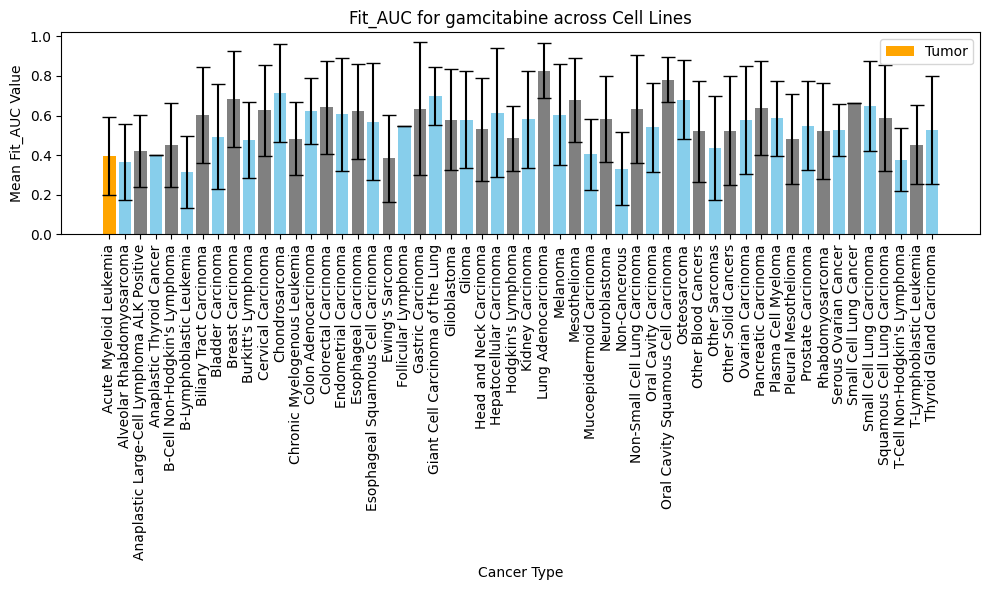

In [15]:
drug_id_to_name_map = joined_data.drugs.set_index('improve_drug_id')['chem_name'].to_dict()

top_drug_ids = top_drugs['improve_drug_id'].tolist()
metrics_of_interest = ['fit_auc', 'fit_ic50']

filtered_data = merged_data[(merged_data['improve_drug_id'].isin(top_drug_ids)) &
                            (merged_data['dose_response_metric'].isin(metrics_of_interest))]
fit_auc_data = filtered_data[filtered_data['dose_response_metric'] == 'fit_auc']
fit_auc_data = fit_auc_data[fit_auc_data.cancer_type != "Unknown"]

fit_auc_data['chem_name'] = fit_auc_data['improve_drug_id'].map(drug_id_to_name_map)

# Define a list of colors to cycle through for the bars. Similar to how PharmacoGX display their data.
colors = ['skyblue', 'grey']

# Add tumor color / label for AML
custom_color_first_bar = 'orange'
custom_label_first_bar = 'Tumor'  

unique_top_drugs = fit_auc_data['chem_name'].unique()

# Create a plot for each of the Top Drugs
for chem_name in unique_top_drugs:
    # Filter data for the current drug
    drug_data = fit_auc_data[fit_auc_data['chem_name'] == chem_name]
    grouped_data = drug_data.groupby('cancer_type')['dose_response_value'].agg(['mean', 'std']).reset_index()
    
    plt.figure(figsize=(10, 6))
    bars = []
    
    for i, (index, row) in enumerate(grouped_data.iterrows()):
        if i == 0:
            # Custom color and label for the first bar
            bar = plt.bar(index, row['mean'], yerr=row['std'], capsize=5, color=custom_color_first_bar)
            bars.append(bar)
        else:
            # cycle through other two colors for the rest of the bars
            color = colors[i % len(colors) - 1]
            bar = plt.bar(index, row['mean'], yerr=row['std'], capsize=5, color=color)
            bars.append(bar)

    plt.legend([bars[0]], [custom_label_first_bar], loc='best')    
    plt.title(f'Fit_AUC for {chem_name} across Cell Lines')
    plt.xlabel('Cancer Type')
    plt.ylabel('Mean Fit_AUC Value')
    plt.xticks(np.arange(len(grouped_data)), grouped_data['cancer_type'], rotation=90, fontsize=10) 
    plt.tight_layout()
    plt.show()

### Plot AUC Values for the Top Drugs by Cancer Types - Box plots


Here we use box plots to provide a better understanding of the distribution of AUC values.

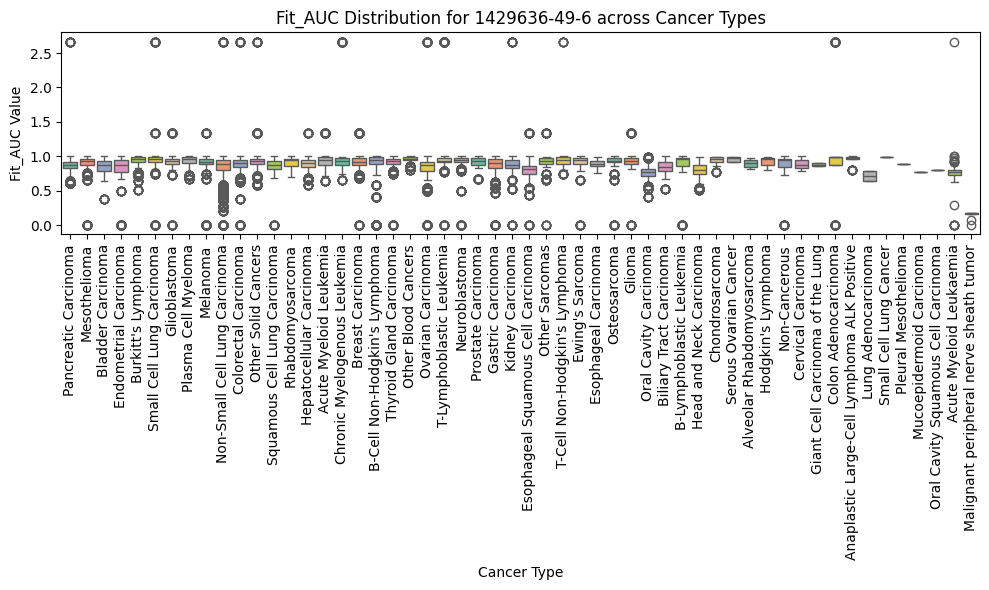

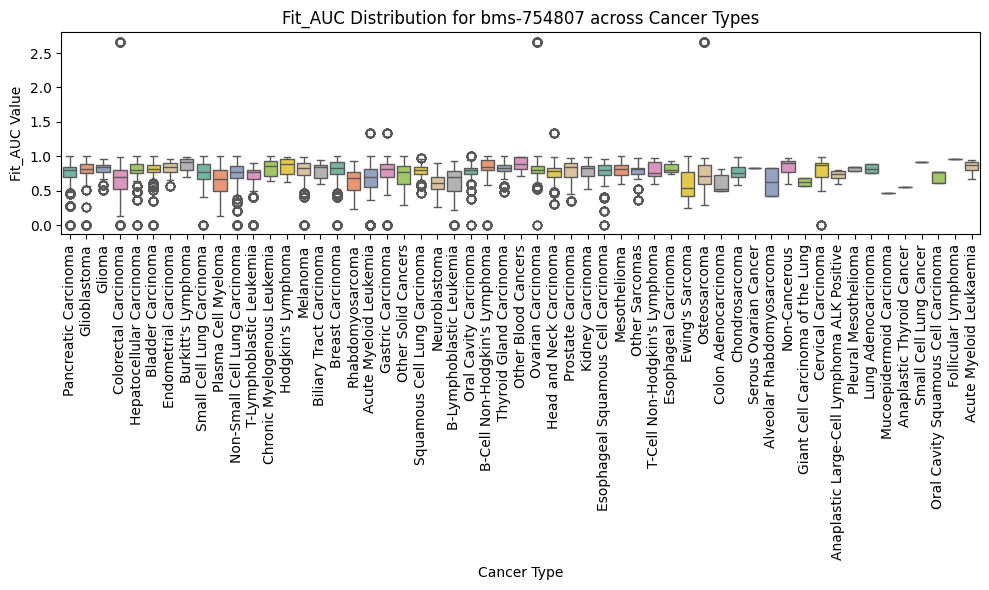

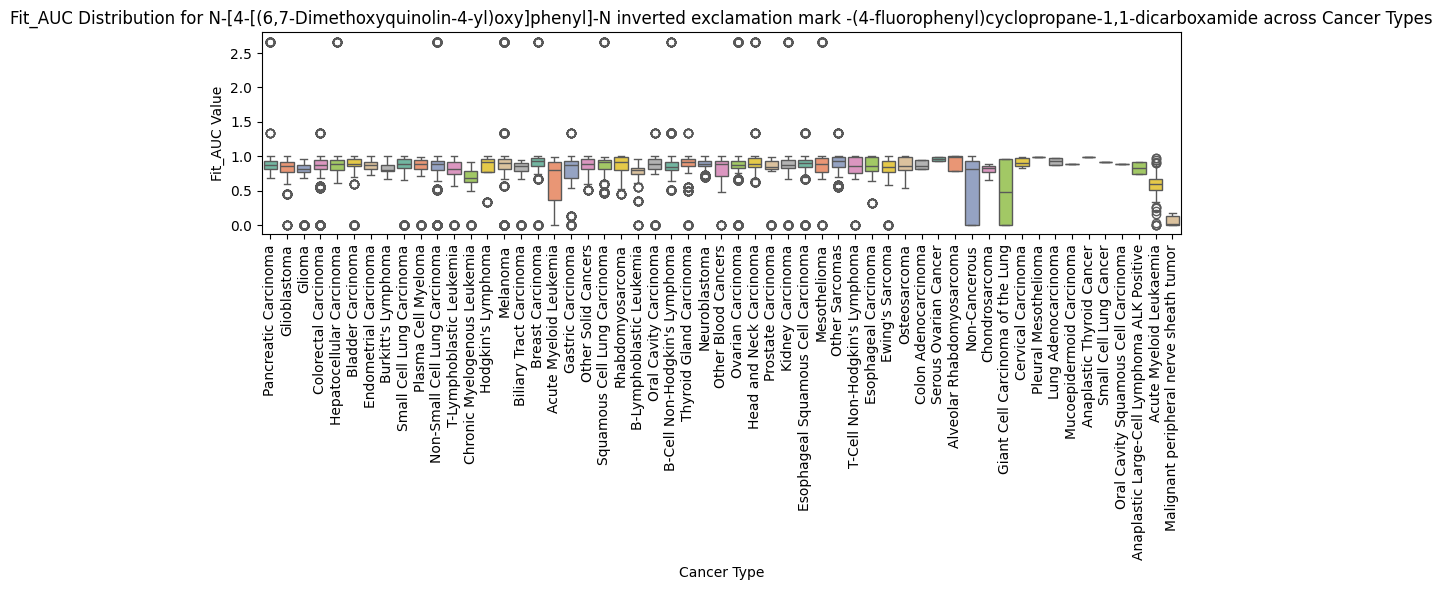

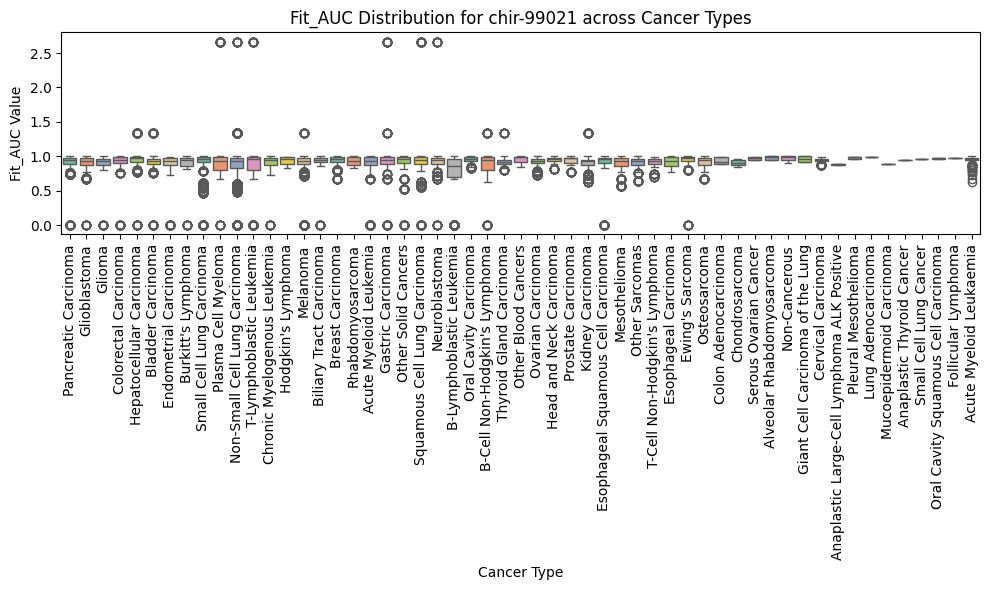

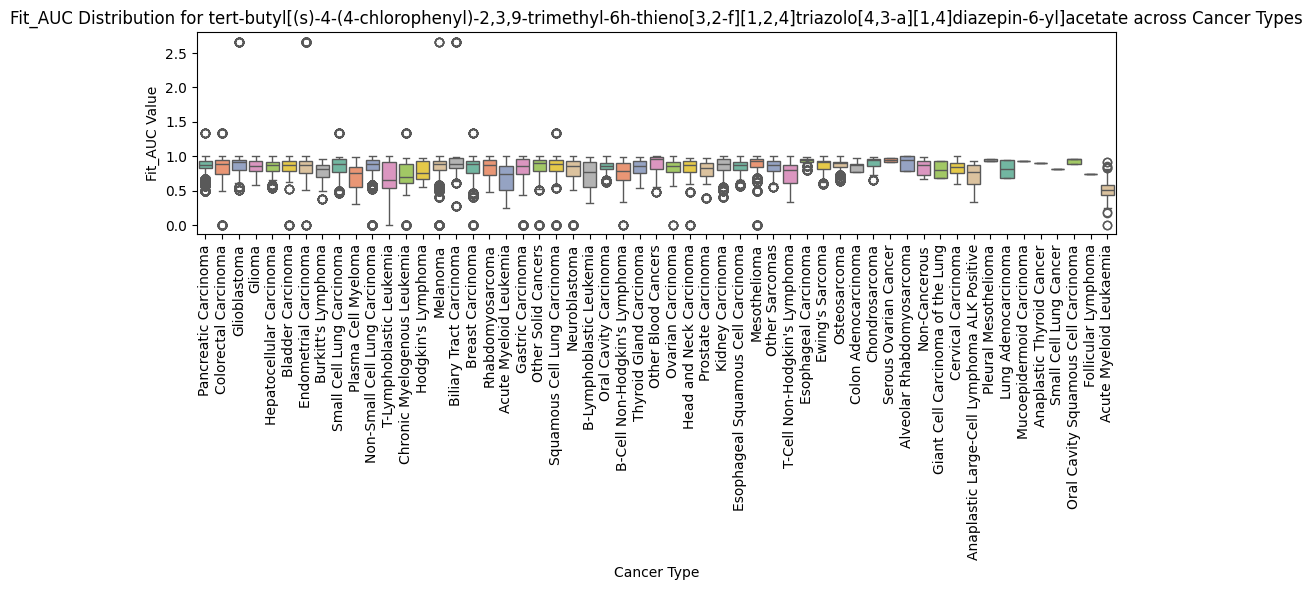

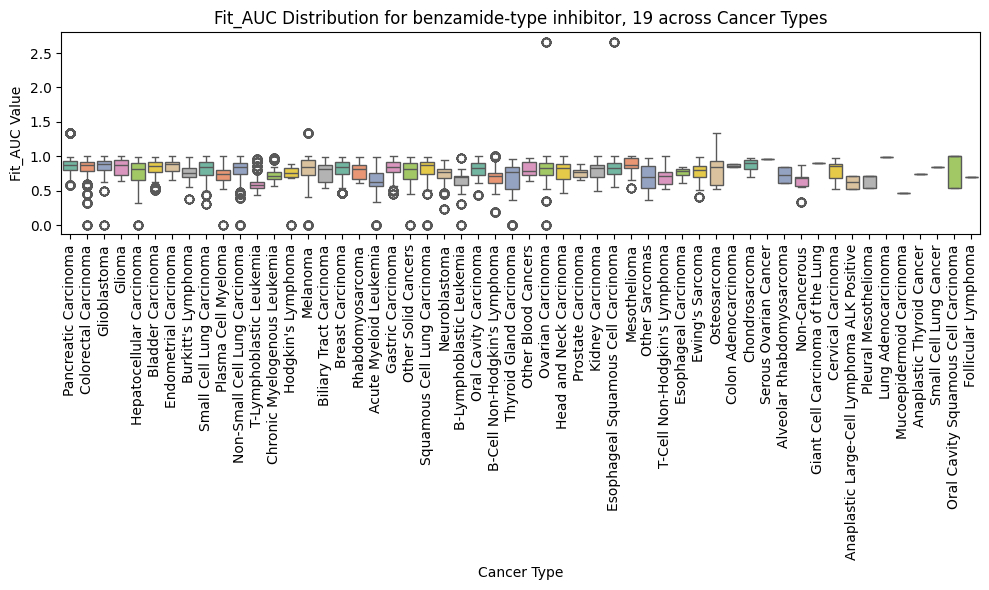

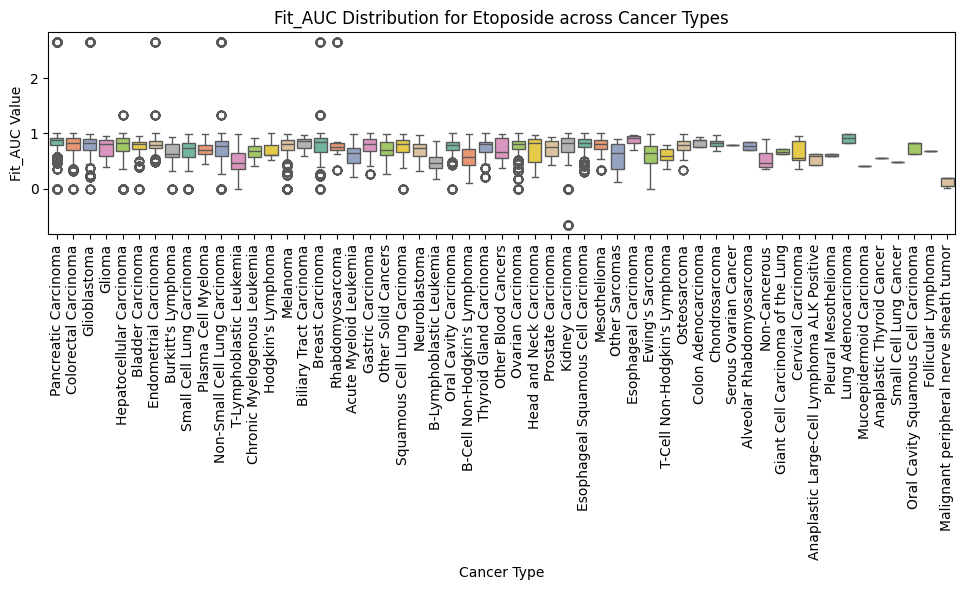

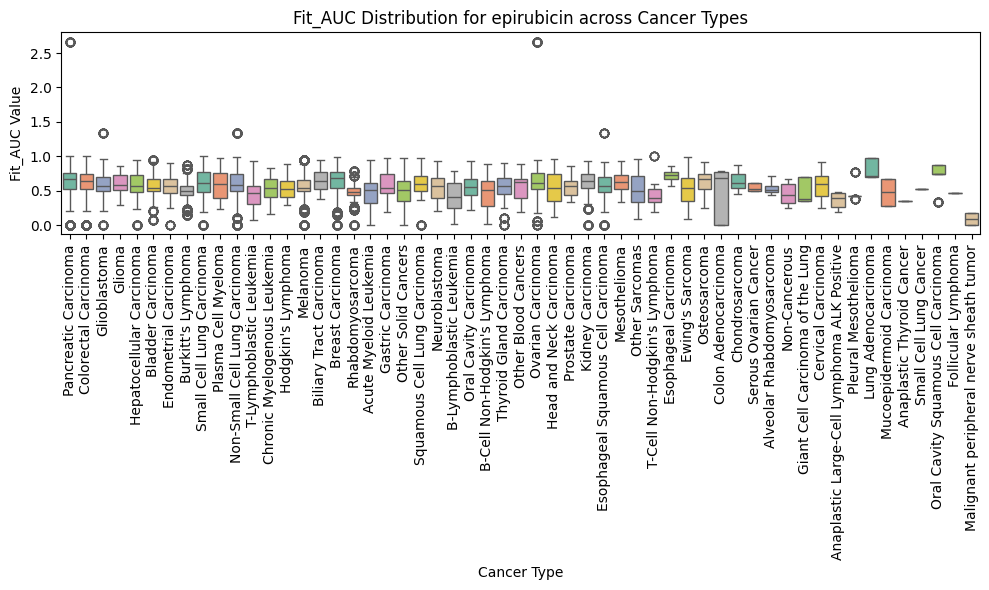

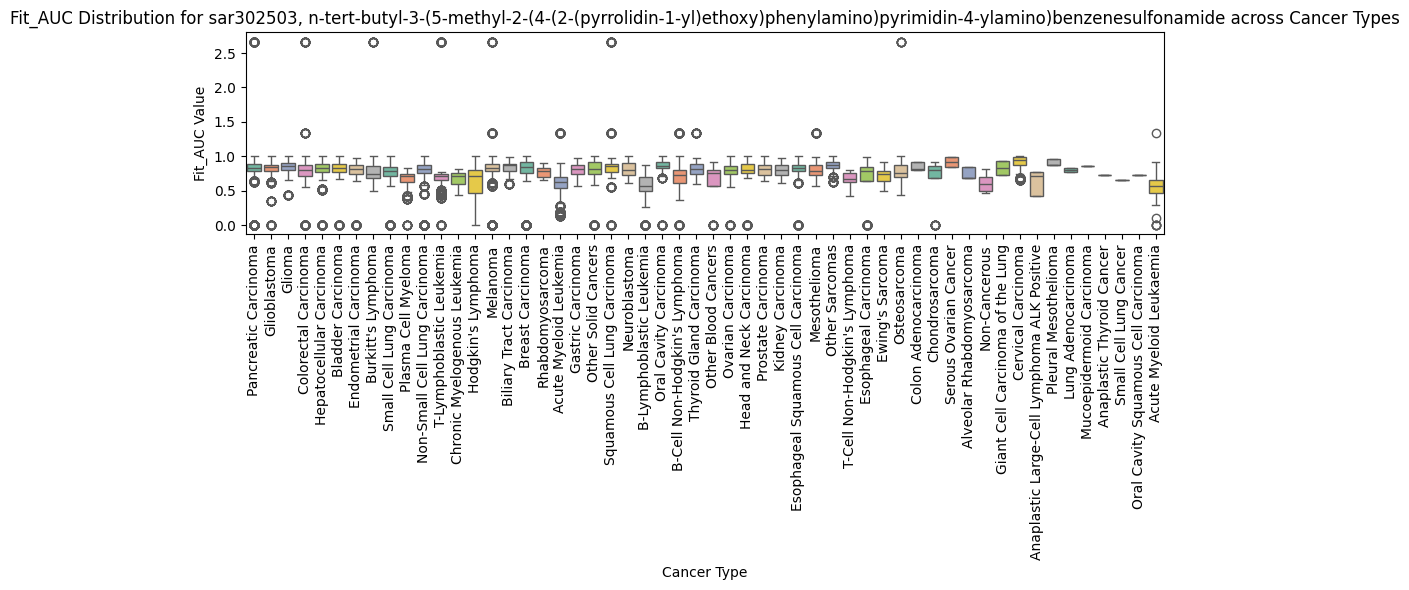

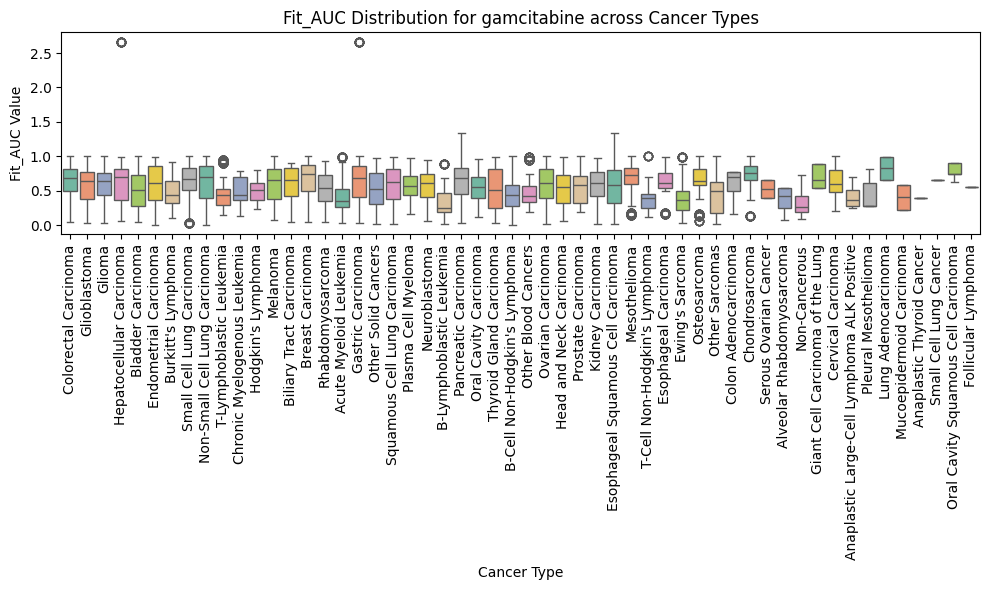

In [16]:
unique_top_drugs = fit_auc_data['chem_name'].unique()

for chem_name in unique_top_drugs:
    # Filter data for the current drug
    drug_data = fit_auc_data[fit_auc_data['chem_name'] == chem_name]
    
    # Create a box plot
    plt.figure(figsize=(10, 6))
    
    # Using seaborn for an enhanced box plot appearance
    sns.boxplot(x='cancer_type', y='dose_response_value', data=drug_data, palette='Set2')
    
    plt.title(f'Fit_AUC Distribution for {chem_name} across Cancer Types')
    plt.xlabel('Cancer Type')
    plt.ylabel('Fit_AUC Value')
    plt.xticks(rotation=90, fontsize=10)  # Set the x-ticks to cancer type names
    plt.tight_layout()
    plt.show()

### Plot AUC Values for the Top Drugs by Cancer Types per Study 


Coderdata has collated numerous sources for drug reponse data. This is important as some studies show different reponses than others.

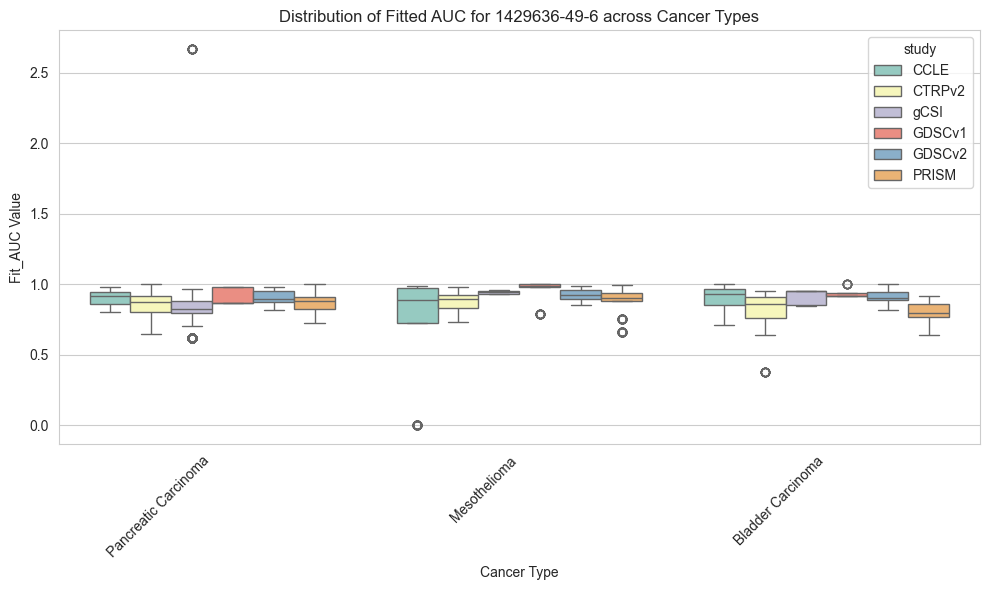

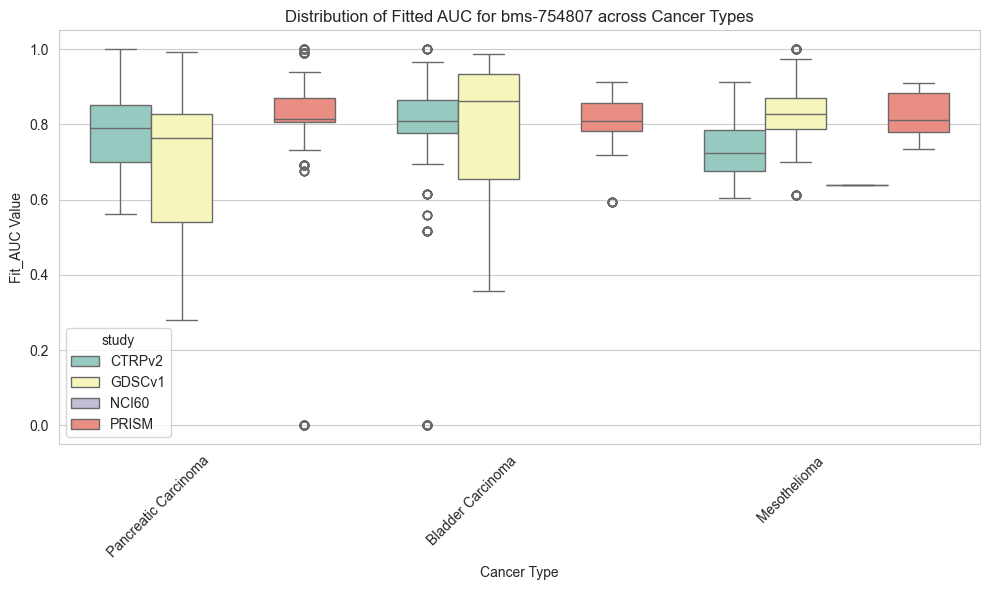

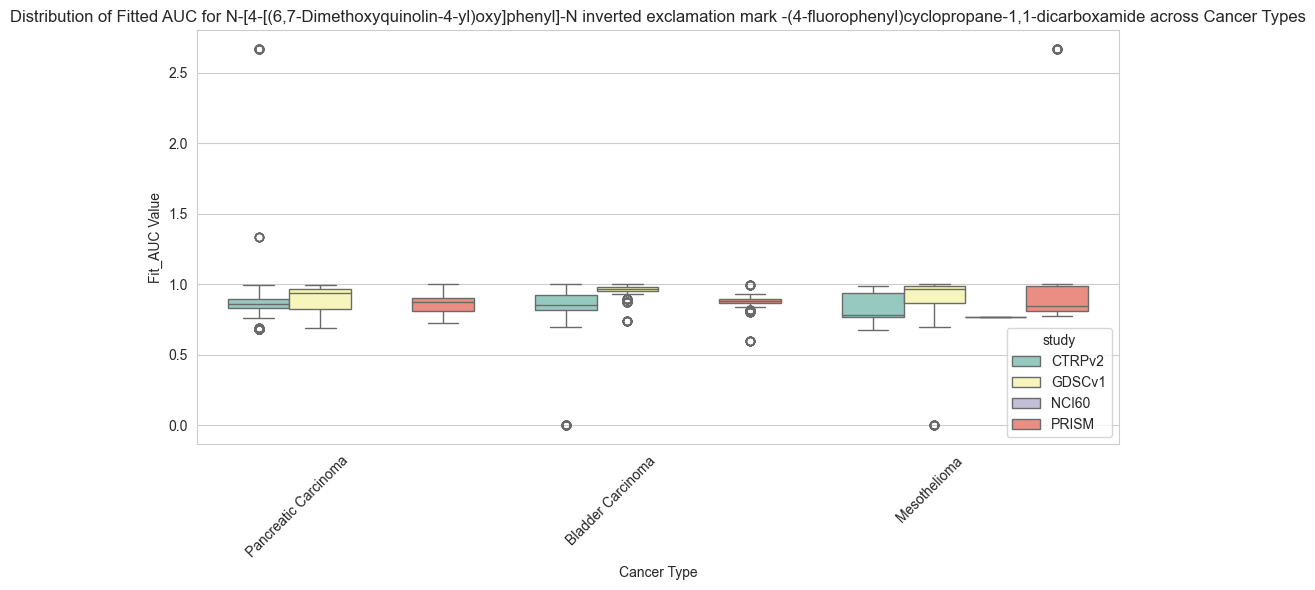

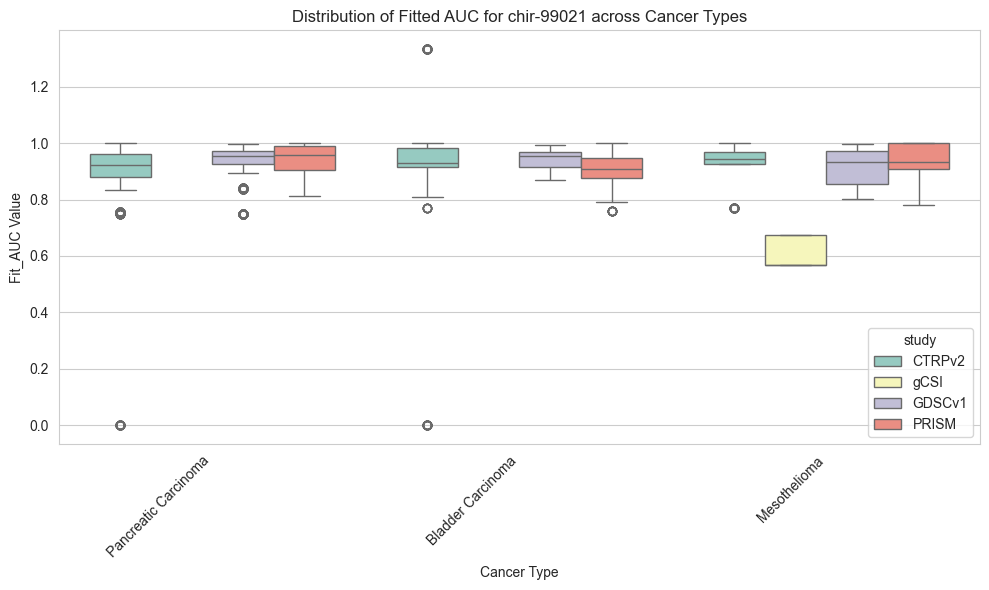

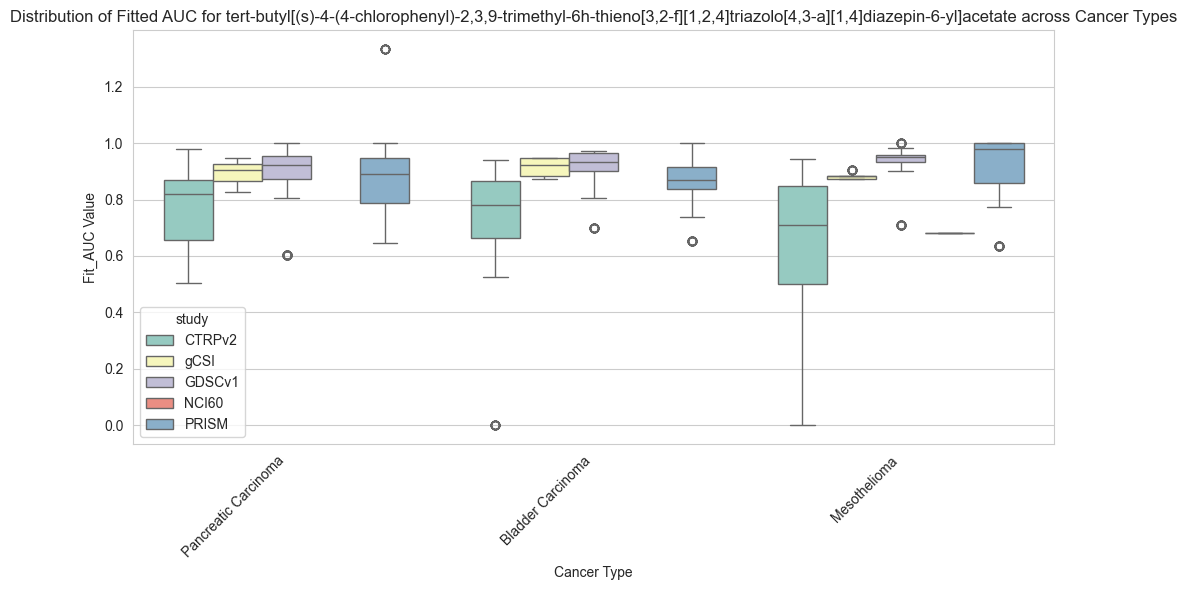

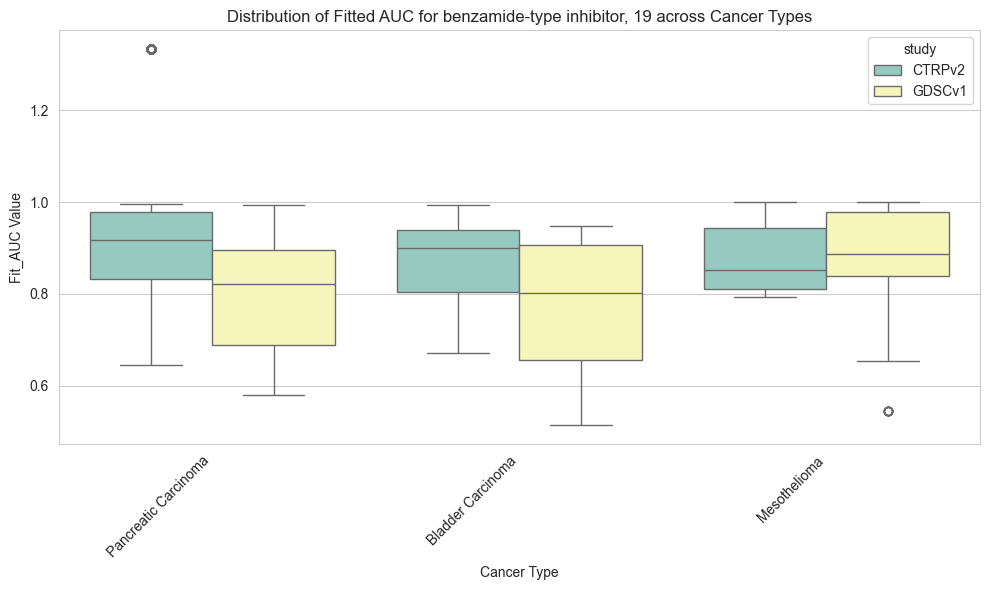

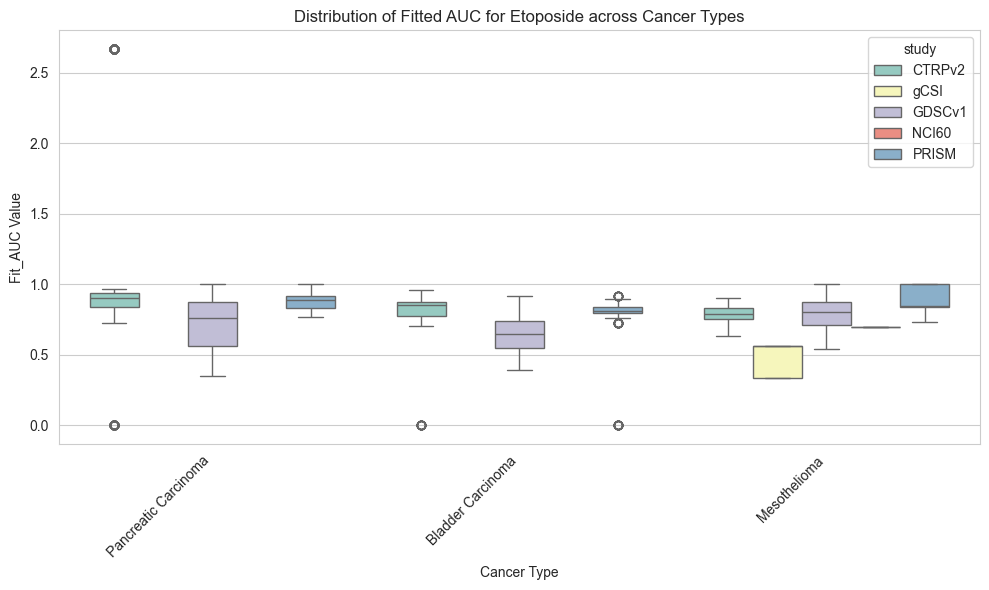

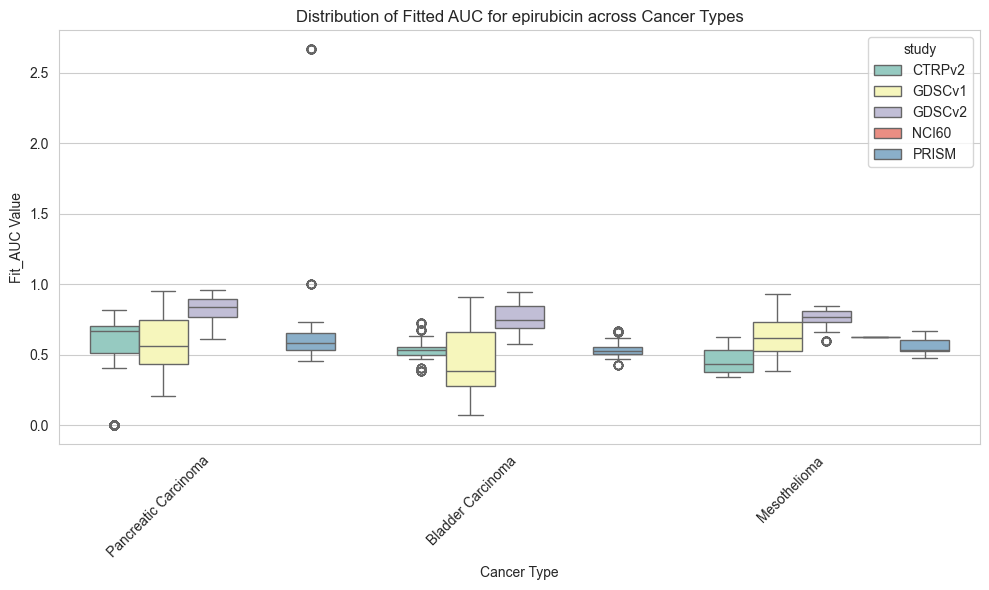

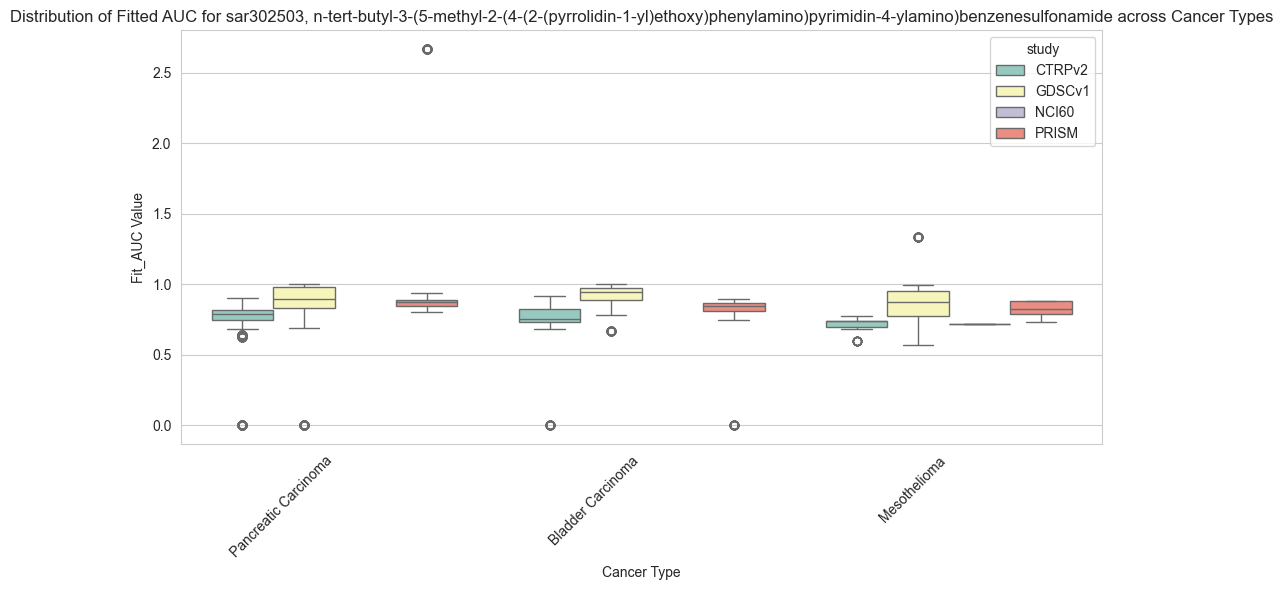

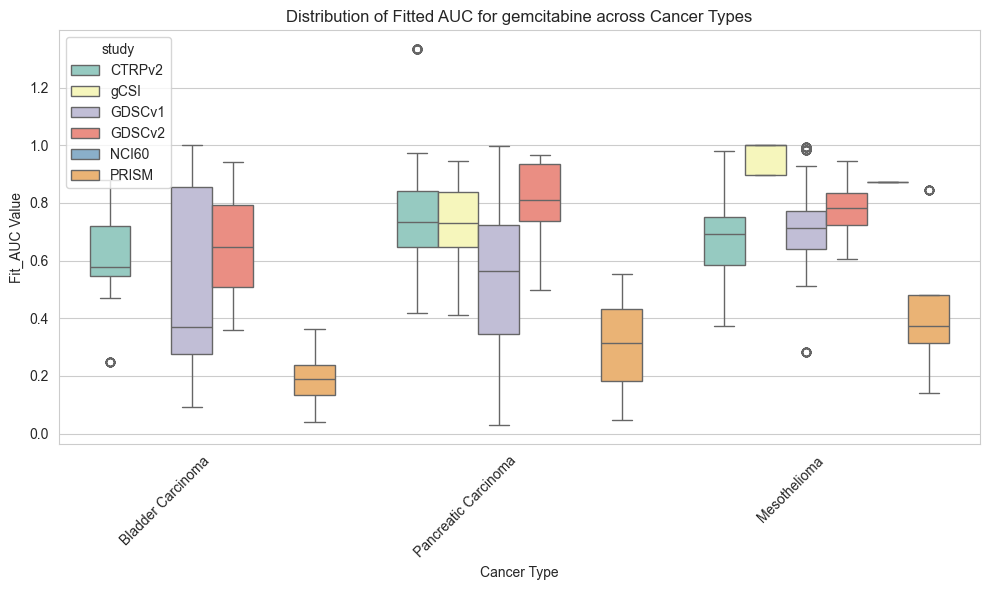

In [82]:
def prepare_mapping(df):
    mapping = {}
    # Iterate over each row
    for index, row in df.iterrows():
        for col in df.columns:
            if pd.notnull(row[col]):
                mapping[row[col]] = row[0]  # Map to the first non-null column value
                break  # Stop at the first non-null value
    return mapping

# Load your mapping file
mapping_df = pd.read_csv('cellLineTypes.csv')

# Flatten the DataFrame to create a mapping, row by row
cancer_type_mapping = prepare_mapping(mapping_df)

# Apply the mapping to your data
fit_auc_data['mapped_cancer_type'] = fit_auc_data['cancer_type'].map(cancer_type_mapping).fillna(fit_auc_data['cancer_type'])

# Filter for the first X unique cancer types after mapping
unique_cancer_types = fit_auc_data['mapped_cancer_type'].unique()[:3]

# Adjust the filtering to use the 'mapped_cancer_type'
filtered_data = fit_auc_data[fit_auc_data['mapped_cancer_type'].isin(unique_cancer_types)]


# Plotting
unique_top_drugs = filtered_data['chem_name'].unique()
for chem_name in unique_top_drugs:
    drug_data = filtered_data[filtered_data['chem_name'] == chem_name]
    if not drug_data.empty:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='mapped_cancer_type', y='dose_response_value', data=drug_data, hue='study', palette='Set3')
        plt.title(f'Distribution of Fitted AUC for {chem_name} across Cancer Types')
        plt.xlabel('Cancer Type')
        plt.ylabel('Fit_AUC Value')
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.tight_layout()
        plt.show()

### Last, we want to explore MEK Inhibitors and how Drug Response Varies Across RAS Mutations


In theory, MEK Inhibitors should be strong candidates for supressing RAS-mutation derived cancers. 

In [21]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7786519/
# Full MEK Inhibitor List
# ["Trametinib","Binimetinib","Selumetinib","Cobimetinib","Cotellic","Mekinist","Koselugo","Mektovi","Pimasertib","Mirdametinib","Refametinib","E6201","GDC-0623","CH5126766","HL-085","SHR7390","TQ-B3234","CS-3006","FCN-159"]

In [22]:
#Ensure chem names are in lowercase and that there are no duplicates
joined_data.drugs['chem_name'] = joined_data.drugs['chem_name'].str.lower()
joined_data.drugs.drop_duplicates(inplace=True)

In [49]:
#These entrez ids map to different RAS Mutations
entrez_id_to_ras_type = {
    4893: 'NRAS',
    3845: 'KRAS',
    3265: 'HRAS'
}
joined_data.mutations['RAS_Type'] = joined_data.mutations['entrez_id'].map(entrez_id_to_ras_type)

# Prepare MEK inhibitor drug list
mek_inhibitor_list = ["trametinib", "binimetinib", "selumetinib", "cotellic", "mekinist", "koselugo", "mektovi", "pimasertib"]

mek_inhibitor_ids = joined_data.drugs[joined_data.drugs.chem_name.str.lower().isin([drug.lower() for drug in mek_inhibitor_list])]['improve_drug_id'].unique().tolist()

# # Create a concatenated string of RAS_Types for samples with multiple mutations
ras_type_concat = joined_data.mutations.groupby('improve_sample_id')['RAS_Type'].apply(lambda x: ','.join(x.dropna().unique())).to_dict()

# Filter experiments DataFrame for samples tested with MEK inhibitors
filtered_experiments = joined_data.experiments[
    (joined_data.experiments['improve_drug_id'].isin(mek_inhibitor_ids)) &
    (joined_data.experiments['dose_response_metric'] == 'fit_auc')
]


# Map concatenated RAS_Type strings to filtered_experiments
filtered_experiments['RAS_Type'] = filtered_experiments['improve_sample_id'].map(ras_type_concat)

filtered_experiments['RAS_Type'] = np.where(
    (filtered_experiments['RAS_Type'].isna()) | (filtered_experiments['RAS_Type'] == ''), 
    'No RAS Mutation', 
    filtered_experiments['RAS_Type']
)

#Ensure that all drugs are mapping to a single drug (rather than its synonyms)
mek_inhibitor_list_normalized = [x.lower() for x in mek_inhibitor_list]
# Create a single chem_name column in joined_data.drugs for matching
joined_data.drugs['chem_name_pref'] = joined_data.drugs['chem_name'].str.lower()

# This mapping associates each improve_drug_id with a "preferred" chem_name from the list
preferred_chem_name_mapping = joined_data.drugs[joined_data.drugs['chem_name_pref'].isin(mek_inhibitor_list_normalized)].drop_duplicates('improve_drug_id').set_index('improve_drug_id')['chem_name'].to_dict()
filtered_experiments['preferred_chem_name'] = filtered_experiments['improve_drug_id'].map(preferred_chem_name_mapping)


### Filter out outliers above 1.5 AUC.

This is only used to make the plots easier to view. This shouldn't be done beyond visualization.

In [51]:
filtered_experiments_cutoff = filtered_experiments[filtered_experiments['dose_response_value'] <= 1.5]


### Final Box Plots!

Below we can see different reponses based on MEK Inhibitor type and RAS Mutation combination

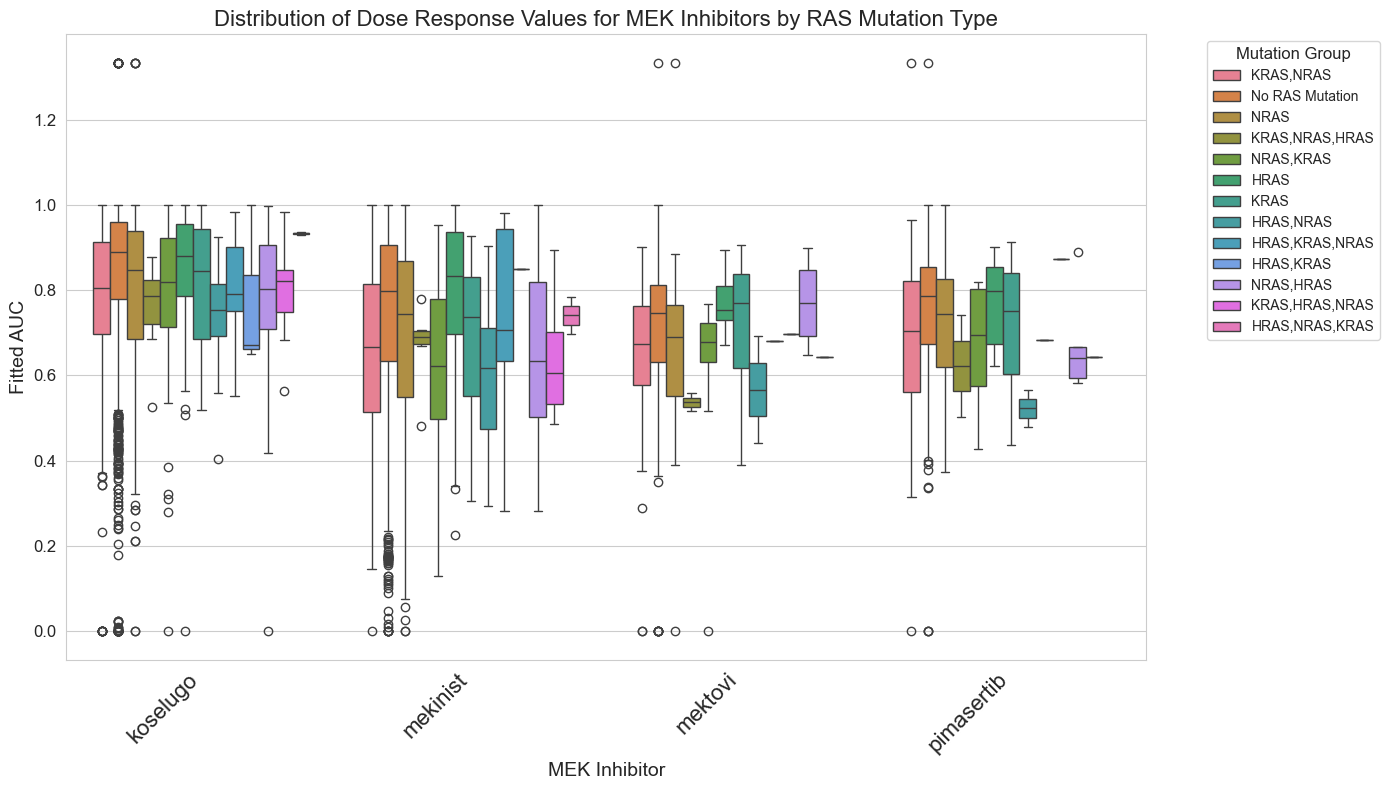

In [53]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(14, 8))

# Create the box plot
sns.boxplot(data=filtered_experiments_cutoff, x='preferred_chem_name', y='dose_response_value', hue='RAS_Type', palette="husl")

plt.xticks(rotation=45, ha='right', fontsize=16)  # Adjust font size as needed
plt.yticks(fontsize=12)
plt.xlabel('MEK Inhibitor', fontsize=14)  # Larger font for axis labels
plt.ylabel('Fitted AUC', fontsize=14)
plt.title('Distribution of Dose Response Values for MEK Inhibitors by RAS Mutation Type', fontsize=16)
plt.legend(title='Mutation Group', title_fontsize='12', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()


plt.show()